<a href="https://colab.research.google.com/github/milindsahay/Neural_style_transfer/blob/master/Neural_style_transfer_compiled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install -q kaggle

In [0]:
! mkdir ~/.kaggle

In [0]:
! cp kaggle.json ~/.kaggle/

In [0]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d teksab/imagenetvggverydeep19mat

 97% 497M/510M [00:08<00:00, 67.8MB/s]
100% 510M/510M [00:08<00:00, 64.9MB/s]


In [6]:
!unzip imagenetvggverydeep19mat.zip

Archive:  imagenetvggverydeep19mat.zip
  inflating: imagenet-vgg-verydeep-19.mat  


In [7]:
!pip install tensorflow==1.15
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
import imageio
import cv2
%matplotlib inline

     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 3.8MB 42.1MB/s 
     |████████████████████████████████| 512kB 43.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=c086d8e1ae91fea769400c8ad146320cda06b1e00ce6a2d6539ad3e9c8309e8f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installatio

In [8]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [9]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

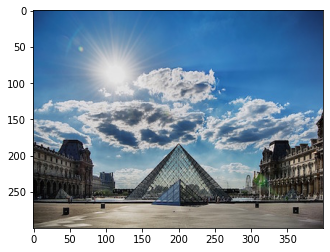

In [10]:
image = plt.imread('louvre.jpg')
plt.imshow(image)

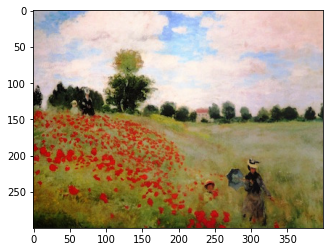

In [11]:
image = plt.imread('monet.jpg')
plt.imshow(image)

In [0]:
def normalise_image(image):
  MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
  width = 300
  height = 400
  dim = (height, width)
  image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  image = np.expand_dims(image, axis=0)
  image = image - MEANS
  return image

In [0]:
def display_image(image):
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    image = image + MEANS
    image = np.clip(image[0], 0, 255).astype('uint8')
    plt.imshow(image)
    imageio.imwrite('output1.jpg', image)

In [0]:
def content_cost(gen_image, con_image):
    #input as tensors
    return (tf.reduce_sum(tf.square(gen_image-con_image)))

In [0]:
def gram_matrix(m):
    #input tensor of shape (n_w*n_h,n_c)
    return tf.matmul(tf.transpose(m),m)

In [0]:
def single_style_cost(gen_image, st_image):
    #input tensor of shape (m,n_w,n_h,n_c)
    
    gen_image = tf.squeeze(gen_image)
    st_image = tf.squeeze(st_image)
    
    #reshaping to (n_w*n_h,n_c)
    n_w, n_h, n_c = gen_image.get_shape().as_list()
    gen_r = tf.reshape(gen_image, shape=[n_w*n_h,n_c])
    st_r = tf.reshape(st_image, shape=[n_w*n_h,n_c])
    
    #calculating gram matrix
    gram_gen = gram_matrix(gen_r)
    gram_st = gram_matrix(st_r)
    
    return tf.reduce_sum(tf.square(gram_st - gram_gen))

In [0]:
def style_cost(model, style_layer):
    
    cost = 0
    weights = float(1/len(style_layer))
    # iterating through each layer
    for layer in style_layer:
        output = model[layer]
        #activations of this layer
        st_im = sess.run(output)
        
        gen_im = output
        cost+= weights*single_style_cost(gen_im,st_im)
    return cost    

In [0]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [0]:
content_path = 'louvre.jpg'
style_path = 'monet.jpg'

In [0]:
def model_nn(sess,content_path, style_path, num_iterations = 2000, learning_rate = 2, alpha=10, beta = 1e-12):

    #loading content image
    content = plt.imread(content_path)
    content = normalise_image(content)
    print(content.shape)
    
    #loading style image
    style = plt.imread(style_path)
    style = normalise_image(style)
    print(style.shape)
    
    #defining content layers and style layers
    content_layer = ['conv5_3']
    style_layer = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

    #defining input image to be styled
    input_image = plt.imread(content_path)
    input_image = normalise_image(input_image)

    model = model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

    #computing content cost
    sess.run(model["input"].assign(content))
    out = model[content_layer[0]]
    act_content = sess.run(out)
    act_gen = out
    con_cost = content_cost(act_gen,act_content)

    #computing style cost
    sess.run(model["input"].assign(style))
    sty_cost = style_cost(model,style_layer)
    total_cost = alpha*con_cost + beta*sty_cost

    #defining optimizer
    opt = tf.train.AdamOptimizer(learning_rate)
    train_step = opt.minimize(total_cost)

    sess.run(tf.global_variables_initializer())
    
    sess.run(model['input'].assign(input_image))

    #initialising best_loss, to select minimin loss from all the calculated losses
    best_loss = float("inf")
    best_out = input_image
   
    for i in range(num_iterations):
    
        sess.run(train_step)
        
        generated_image = sess.run(model['input'])

        cst = sess.run(total_cost)
        #updating best loss and best image corresponding to minimum loss encountered yet
        if cst<best_loss:
          best_loss = cst
          best_out = generated_image
        
        if i%100 == 0:
            t_c, c_c, s_c = sess.run([total_cost, con_cost, sty_cost])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(t_c))
            print("content cost = " + str(c_c))
            print("style cost = " + str(s_c))
            
    
    return best_out

(1, 300, 400, 3)
(1, 300, 400, 3)
Iteration 0 :
total cost = 467228400.0
content cost = 805118.0
style cost = 4.5917724e+20
Iteration 100 :
total cost = 30210272.0
content cost = 772577.9
style cost = 2.2484492e+19
Iteration 200 :
total cost = 16336105.0
content cost = 630718.2
style cost = 1.0028923e+19
Iteration 300 :
total cost = 11332899.0
content cost = 558499.1
style cost = 5.747908e+18
Iteration 400 :
total cost = 9224451.0
content cost = 510189.47
style cost = 4.1225565e+18
Iteration 500 :
total cost = 8252940.0
content cost = 478861.25
style cost = 3.4643278e+18
Iteration 600 :
total cost = 7654190.0
content cost = 457047.84
style cost = 3.0837112e+18
Iteration 700 :
total cost = 7235855.5
content cost = 436897.6
style cost = 2.8668795e+18
Iteration 800 :
total cost = 7028741.0
content cost = 425394.5
style cost = 2.7747957e+18
Iteration 900 :
total cost = 6793169.0
content cost = 412329.5
style cost = 2.669874e+18
Iteration 1000 :
total cost = 6616548.0
content cost = 400618.

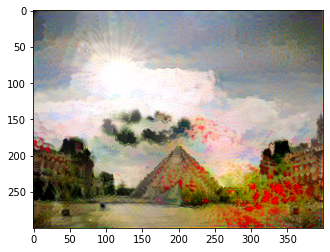

In [21]:
im = model_nn(sess, content_path, style_path)
display_image(im)